# Нейросести

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
  sys.path.append(os.path.join(ROOT_DIR, 'MyDrive', 'src'))
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir)[:5])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Содержимое директории %s: %s /Users/adzhumurat/PycharmProjects/ai_product_engineer/data ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


Загружаем датасет, с которым работали на занятии по кластеризации

In [3]:
import pickle

file_path = os.path.join(root_data_dir, 'clustering.pkl')

# читаем исходный файл
with open(file_path, 'rb') as f:
    data_clustering = pickle.load(f)

#  распаковываем данные
input_X= np.array(data_clustering['X'])
input_Y = np.array(data_clustering['Y'])

print(input_X.shape, input_Y.shape)

(100, 2) (100,)


/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_90035/1225688744.py:7: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath._reconstruct.
  data_clustering = pickle.load(f)


Решаем задачу классификации, поэтому функция активации - сигмоида:

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
sigmoid(0.0)

np.float64(0.5)

Рандомная инциализация параметров

dim - размерность входного вектора (в нашем случае задача двумерная)

Описывает "нейросеть", которая является по сути перемножением матриц

Когда веса обучены - можно делать предсказание

In [7]:
from sklearn.model_selection import train_test_split

class NeuralNetworkLogReg:
  def __init__(self, layer_dim: int):
    """
    :param layer_dim: размерность слоя, должна совпадать с количеством фичей датасета
    """
    self.dim = layer_dim
    self.layer_params = self.initialize_parameters()
    self.layer_grads = self.initialize_grads()
    # выход из последней функции активации сети
    self.layers_output = None
    self.batch_size = None
    self.learning_rate = None
    self.loss = []

  def initialize_parameters(self):
      # размерность будет такая, сколько фичей в дасете (в нашем случае две)
      w = np.random.randn(self.dim, 1) * 0.01
      b = np.random.random()
      layer_params = {"w": w, "b": b}
      return layer_params

  def initialize_grads(self):
      layer_grads = {"dw": None, "db": None}
      return layer_grads

  def linear_layer(self, input_data):
    output = sigmoid(
        np.dot(input_data, self.layer_params["w"]) + self.layer_params["b"]
    )
    return output

  def forward_pass(self, X, Y):
      self.batch_size = X.shape[0]  # сохраняем размер батча для обратного прохода
      self.layers_output = self.linear_layer(X)
      self.error = self.layers_output - Y
      # LogLoss - как в логистической регрессии
      loss = (
          (-1.0 / self.batch_size) * np.sum(
              Y * np.log(self.layers_output) +
              (1.0 - Y) * (np.log(1.0 - self.layers_output))
          )
      )
      self.loss.append(loss)

  def backward_pass(self, X):
      self.layer_grads["dw"] = (1.0 / self.batch_size) * np.dot(X.T, self.error)
      self.layer_grads["db"] = (1.0 / self.batch_size) * np.sum(self.error)

  def update_params(self):
      #update parameters
      self.layer_params["w"] = (
          self.layer_params["w"] - self.learning_rate * self.layer_grads["dw"]
      )
      self.layer_params["b"] = (
          self.layer_params["b"] - self.learning_rate * self.layer_grads["db"]
      )
  
  def gradient_descent(self, X, Y):
      for i in range(self.iterations):
          self.forward_pass(X, Y)
          self.backward_pass(X)
          self.update_params()
          if i % 10 == 0:
              print ("Loss after iteration %i: %f" %(i, self.loss[-1])) 

  def predict(self, X, threshold=0.5):    
      # number of example
      m = X.shape[0]
      y_pred = np.zeros((m, 1))
      predicted_proba = self.linear_layer(X)
      # превращаем вероятности в метки классов
      y_pred[np.where(predicted_proba > threshold)] = 1.0
      y_pred[np.where(predicted_proba <= threshold)] = 0.0
      return y_pred

  def train(self, train_x, train_y, test_x, test_y, iterations, learning_rate):
      self.learning_rate = learning_rate
      self.iterations = iterations
      train_y = train_y.reshape(-1, 1)
      test_y = test_y.reshape(-1, 1)
      # logger.info('w: %s', w)
      self.gradient_descent(train_x, train_y)
      # predict 
      train_pred_y = self.predict(train_x)
      print('Predicted shape: %s, sum in prediction %d' % (train_pred_y.shape, train_pred_y.sum()))
      test_pred_y = self.predict(test_x)
      print("Train Acc: {} %".format(100 - np.mean(np.abs(train_pred_y - train_y)) * 100))
      print("Test Acc: {} %".format(100 - np.mean(np.abs(test_pred_y - test_y)) * 100))

train_x, test_x, train_y, test_y = train_test_split(
    input_X, input_Y, test_size=.3, stratify=input_Y, random_state=RANDOM_SEED
)

num_features = input_X.shape[1]
log_reg = NeuralNetworkLogReg(layer_dim=num_features)
log_reg.train(train_x, train_y, test_x, test_y, iterations = 150, learning_rate = 0.5)

Loss after iteration 0: 0.703394
Loss after iteration 10: 0.300724
Loss after iteration 20: 0.228263
Loss after iteration 30: 0.200844
Loss after iteration 40: 0.187162
Loss after iteration 50: 0.179303
Loss after iteration 60: 0.174385
Loss after iteration 70: 0.171126
Loss after iteration 80: 0.168875
Loss after iteration 90: 0.167271
Loss after iteration 100: 0.166101
Loss after iteration 110: 0.165231
Loss after iteration 120: 0.164573
Loss after iteration 130: 0.164069
Loss after iteration 140: 0.163680
Predicted shape: (70, 1), sum in prediction 35
Train Acc: 98.57142857142857 %
Test Acc: 100.0 %


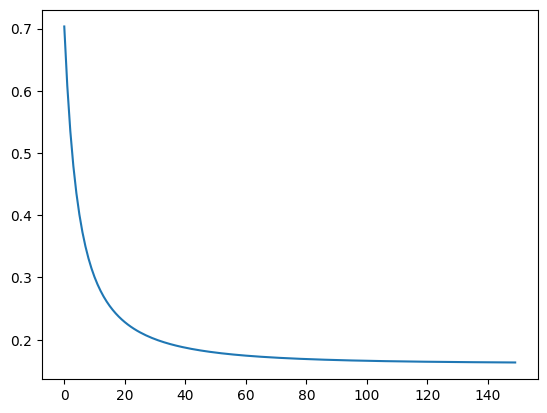

In [8]:
from matplotlib import pyplot as plt

plt.plot(list(range(len(log_reg.loss))), log_reg.loss)

# PyTorch

Создадим модель логиcтической регрессии на Pytorch

In [9]:
import pandas as pd

input_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'final_dataset.zip'), compression='zip')

input_dataset_df.head()

,content_id,num_views,num_positve_actions,num_smiles,num_saves,num_shares,num_repubs,num_comments,num_days_on_service,featured_approval_content_declined,declined_reason,best_class,approved,hard_shotted,soft_shotted
0,IzpfrtD,127770,12725,12455,168,141,556,1784,25,0.0,NaN,NaN,NaN,NaN,NaN
1,FibDyiC,86090,6180,5704,173,383,289,6016,5,1.0,racism,approved,0.908444,0.033255,0.058302
2,LUkUBEm,78286,5228,4944,376,29,162,165,6,0.0,NaN,approved,0.994736,0.002517,0.002748
3,zPrfyiz,76931,5664,5506,231,8,151,395,5,1.0,politics_religion,approved,0.987415,0.008829,0.003755
4,eNAyJnh,72021,6148,5844,453,16,261,113,5,1.0,racism,approved,0.989974,0.005185,0.004841


Датасет с текстом

In [10]:
ocr_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'ocr_dataset.zip'), compression='zip')

ocr_dataset_df.head()

,content_id,text
0,muTKNpX,Like this if you think Joe Biden\nshould to go...
1,oCsKxRF,This series is garbage.\nIt's so unrealistic
2,hEZuhDH,"Phone in one hand, your mum in the other\nidie..."
3,KuUnefc,vsauce.\nmichael here.\nyou cant contain me fo...
4,ykIaYzU,Fatphobia\nFatphobia is a phobia in which over...


Функция для разбиения на валидацию и контроль

In [13]:
from sklearn.model_selection import train_test_split

def split_dataset(source_df: pd.DataFrame, valid_train_set_size = 0.3):
  y = source_df.featured_approval_content_declined

  content_ids = source_df['content_id']

  x_train, x_test_ids, y_train, y_test = (
      train_test_split(
          content_ids, y, test_size=valid_train_set_size, random_state=RANDOM_SEED, stratify=y
      )
  )

  test_df = pd.DataFrame({'content_id': x_test_ids, 'y': y_test})
  train_df = pd.DataFrame({'content_id': x_train, 'y': y_train})
  print('Positive target share %.4f' % (train_df['y'].value_counts(normalize=True)[1]))

  return train_df, test_df

Удаляем "плохие" категории

In [14]:
non_prediction_declined_reason = [
    'nudity_censored_genitals', 'school_shooting_fights', 'not_safe_for_work', 'bodily_fluids', 'pity'
]

input_dataset_df.loc[
    input_dataset_df['declined_reason'].isin(non_prediction_declined_reason), 'featured_approval_content_declined'
] = 0.0

# т.к. таргет поменялся, нужно повторное разбиение
train_df, test_df = split_dataset(input_dataset_df)

train_df.head()

Positive target share 0.2499


,content_id,y
50644,FyGigPx,1.0
70612,hYWHmVI,1.0
36427,CnoRjMg,0.0
22337,fFtZzvp,0.0
61597,ngCAQkz,0.0


Обучаем трансформер текста в csr матрицу

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word', lowercase=True, token_pattern=r'\b[\w\d]{3,}\b', min_df=0.0001
)

vectorizer.fit(ocr_dataset_df.text.values)

TfidfVectorizer(min_df=0.0001, token_pattern='\\b[\\w\\d]{3,}\\b')

In [16]:
from scipy.sparse import csr_matrix

def prepare_tfidf(content_df, text_df, tfidf_vectorizer) -> csr_matrix:
  # присоединяем текстовую информацию
  ocr_dataset_train = (
      content_df[['content_id']]
      .merge(text_df, how='left')
  )
  # заполняем пропуски
  ocr_dataset_train.text.fillna('', inplace=True)
  # вычисляем tf-idf
  ocr_features = tfidf_vectorizer.transform(ocr_dataset_train.text.values)

  return ocr_features

train_ocr_dataset = prepare_tfidf(train_df, ocr_dataset_df, vectorizer)
test_ocr_dataset = prepare_tfidf(test_df, ocr_dataset_df, vectorizer)
train_ocr_dataset

/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_90035/426236483.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ocr_dataset_train.text.fillna('', inplace=True)
/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_90035/426236483.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1031893 stored elements and shape (70000, 13826)>

Для торча данные нужно специальным образом подготовить

In [17]:
import torch
from torch.utils.data import Dataset

class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(
            self.features[idx].toarray()[0]
        ).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

# создаём сразу тренировочный и тестовый датасет, pd.series в качестве таргета не пойдёт, нужен numpy.array
train_dataset = SparseFeaturesDataset(train_ocr_dataset, train_df['y'].values)
test_dataset = SparseFeaturesDataset(test_ocr_dataset, test_df['y'].values)
#  мы уже  знаем, что количество фичей соответствует  количеству нейронов в слое, поэтому сохраним это число в отдельную константу
UNIQUE_WORDS_N = test_ocr_dataset.shape[1]
test_dataset

Обучение нейросети будем запускать на Catalyst, это такой "фреймворк для фреймворка" PyTorch

In [20]:
# !pip install catalyst==21.12

     |████████████████████████████████| 544 kB 13.7 MB/s 
     |████████████████████████████████| 120 kB 44.6 MB/s 
     |████████████████████████████████| 596 kB 39.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Подробнее про Runner [тут](https://medium.com/pytorch/catalyst-102-core-trinity-experiment-runner-and-callback-54adc384b57c) а тут [подробнее про Catalyst](https://github.com/catalyst-team/catalyst#minimal-examples)

In [18]:
# %load_ext tensorboard

Чтобы потом запустить Tensorboard

In [ ]:
# import torch
# from torch.utils.tensorboard import SummaryWriter
# summary_writer = SummaryWriter(log_dir=os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'logs'))
# summary_writer

Для создания нейросети на PyTorch можно использовать готовые классы, например

```python
nn = nn.Sequential(
  nn.Linear(3, 10),
  nn.ReLu(),
  nn.Linear(10, 20),
  nn.ReLu(),
  nn.Linear(20, 3),
)

nn(X)
```

In [21]:
from torch import nn, optim
from torch.nn import functional as F

from catalyst import dl, metrics
from torch.utils.data import DataLoader

UNIQUE_LABELS_N = 2  # т.к. решаем задачу бинарной классификации, у нас два класса

# Внимание! создаём нейросеть!
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)
# Всё, нейросеть создана
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=0)

loaders = {
    "train": DataLoader(train_dataset, batch_size=32),
    "valid": DataLoader(test_dataset, batch_size=32),
}

class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device))

    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveMetric(compute_on_call=False)
            for key in ["loss"]
        }

    def handle_batch(self, batch):
        x, y = batch
        # run model forward pass
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        self.batch_metrics.update({"loss": loss})
        for key in ["loss"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)
        # run model backward pass
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def on_loader_end(self, runner):
        for key in ["loss"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

runner = CustomRunner()
# model training
runner.train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    logdir=os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'logs'),
    num_epochs=80,
    verbose=True,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    callbacks=[
        dl.EarlyStoppingCallback(
            patience=10, loader_key="valid", metric_key="loss", minimize=True
        )
    ]
)
# TODO: понять, почему не работает dl.OptimizerCallback(metric_key="loss"), dl.SchedulerCallback(metric_key="loss", loader_key="valid"),

/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:630: UserWarning: No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run backward pass during ``runner.handle_batch``?
  "No ``IOptimizerCallback/OptimizerCallback`` were found "
/usr/local/lib/python3.7/dist-packages/catalyst/core/runner.py:638: UserWarning: No ``ISchedulerCallback/SchedulerCallback`` were found while runner.scheduler is not None.Do you make scheduler step during ``runner.handle_batch``?
  "No ``ISchedulerCallback/SchedulerCallback`` were found "


1/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (1/80) loss: 0.8238027671337124


1/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (1/80) loss: 0.9108777577638627
* Epoch (1/80) 


2/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (2/80) loss: 0.7833074444804875


2/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (2/80) loss: 1.0228337154706304
* Epoch (2/80) 


3/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (3/80) loss: 0.7796366943597806


3/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (3/80) loss: 1.1247377705732966
* Epoch (3/80) 


4/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (4/80) loss: 0.7797402968645089


4/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (4/80) loss: 1.2070132123311375
* Epoch (4/80) 


5/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (5/80) loss: 0.7798490908690855


5/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (5/80) loss: 1.2788333447774238
* Epoch (5/80) 


6/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (6/80) loss: 0.7810996619973877


6/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (6/80) loss: 1.3430349504470822
* Epoch (6/80) 


7/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (7/80) loss: 0.7821883729832515


7/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (7/80) loss: 1.4013684762636813
* Epoch (7/80) 


8/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (8/80) loss: 0.7833499282973154


8/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (8/80) loss: 1.4555123497962934
* Epoch (8/80) 


9/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (9/80) loss: 0.7844323190620961


9/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (9/80) loss: 1.5042071037928286
* Epoch (9/80) 


10/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (10/80) loss: 0.7851744204657417


10/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (10/80) loss: 1.5493053261121121
* Epoch (10/80) 


11/80 * Epoch (train):   0%|          | 0/2188 [00:00<?, ?it/s]

train (11/80) loss: 0.786088425016403


11/80 * Epoch (valid):   0%|          | 0/938 [00:00<?, ?it/s]

valid (11/80) loss: 1.5886810333569836
* Epoch (11/80) 
Top best models:
/content/drive/MyDrive/hse_nlp_2021/logs/checkpoints/train.1.pth	0.9109


Проверка качества модели

In [ ]:
from sklearn.metrics import accuracy_score
# model inference
res = []
for logits in runner.predict_loader(loader=loaders["valid"]):
    res.append(logits.detach().cpu().numpy())
test_pred = np.vstack(res)

test_loss = (
    F.cross_entropy(
        torch.from_numpy(test_pred),
        torch.from_numpy(test_df['y'].values).long()
    )
)
logger.info(
    'Loss: %.3f, accuracy %.3f',
    test_loss.cpu().numpy(),
    accuracy_score(test_df['y'].values, test_pred.argmax(-1))
)

2022-04-15 08:17:13,340 : Loss: 1.589, accuracy 0.726


Сравним с логистической регрессией из sklearn

Готовим данные

In [ ]:
def prepare_tfidf_df(content_df, text_df) -> csr_matrix:
  # присоединяем текстовую информацию
  ocr_dataset = (
      content_df[['content_id']]
      .merge(text_df, how='left')
  )
  # заполняем пропуски
  ocr_dataset.text.fillna('', inplace=True)

  return ocr_dataset

train_dataset_df = prepare_tfidf_df(train_df, ocr_dataset_df)
test_dataset_df = prepare_tfidf_df(test_df, ocr_dataset_df)
test_dataset_df.head(1)

,content_id,text
0,ujdztki,Nanu subscribe\n472 comments\n600D FUCKING LOR...


Обучаем модель

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logger.info('Training started...')
sklearn_pipeline = Pipeline(
    (
        ('vect', TfidfVectorizer(analyzer='word', lowercase=True, token_pattern=r'\b[\w\d]{3,}\b', min_df=0.0001)),
        ('cls', LogisticRegression(max_iter=500))
    )
)
sklearn_pipeline.fit(train_dataset_df['text'], train_df['y'])
logger.info('Training finished')

sklearn_train_pred = sklearn_pipeline.predict_proba(train_dataset_df['text'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_df['y'].values.astype('int')))
logger.info('Train> Loss: %.3f, accuracy %.3f', float(sklearn_train_loss), accuracy_score(train_df['y'], sklearn_train_pred.argmax(-1)))

sklearn_test_pred = sklearn_pipeline.predict_proba(test_dataset_df['text'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_df['y'].values.astype('int')))
logger.info('Valid> Loss: %.3f, accuracy %.3f', float(sklearn_test_loss), accuracy_score(test_df['y'], sklearn_test_pred.argmax(-1)))

2022-04-15 08:58:45,940 : Training started...
2022-04-15 08:58:52,088 : Training finished
2022-04-15 08:58:53,431 : Train> Loss: 0.527, accuracy 0.813
2022-04-15 08:58:53,964 : Valid> Loss: 0.545, accuracy 0.793


Вывод: логрегрессия показала лучшее качество, чем нейросеть

Как улучшить результат?

* превратить текст в эмбеддинги
  * с помощью SVD
  * с помощью Word2Vec
* добавить больще слоёв
* воспользоваться другой архтектурой сети 